**Group Members**

1.Taitip Suphasiriwattana (6310422009)

2.Karn Wawwiriya (6310422021)

3.Thanaporn Rundon (6310422025)

# **Load Dependencies**

In [ ]:
!pip install pycaret

In [ ]:
import pandas as pd
from pycaret.clustering import *

# **Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BADS7105/Supermarket Data.csv')
df['SHOP_DATE'] = df['SHOP_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
display(df.head())
print(df.info())

In [ ]:
#Create New Columns
new_df = df.join(pd.get_dummies(df['CUST_LIFESTAGE'] ,prefix='LIFESTAGE'))
new_df = new_df.join(pd.get_dummies(df['CUST_PRICE_SENSITIVITY'] ,prefix='PRICE_SENSITIVE'))
new_df = new_df.join(pd.get_dummies(df['BASKET_DOMINANT_MISSION'] ,prefix='BASKET_MISSION'))
new_df['SHOP_WEEKEND'] = np.where(new_df['SHOP_WEEKDAY'].isin([1,7]) , 1 ,0)
new_df['SHOP_WEEKDAY'] = np.where(new_df['SHOP_WEEKDAY'].isin([2,3,4,5,6]) , 1 ,0)
new_df.head(2)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION,LIFESTAGE_OA,LIFESTAGE_OF,LIFESTAGE_OT,LIFESTAGE_PE,LIFESTAGE_YA,LIFESTAGE_YF,PRICE_SENSITIVE_LA,PRICE_SENSITIVE_MM,PRICE_SENSITIVE_UM,PRICE_SENSITIVE_XX,BASKET_MISSION_Fresh,BASKET_MISSION_Grocery,BASKET_MISSION_Mixed,BASKET_MISSION_Nonfood,BASKET_MISSION_XX,SHOP_WEEKEND
0,200732,2007-10-05,1,17,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000583261,UM,YF,994107800547472,L,MM,Top Up,Grocery,STORE00001,LS,E02,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
1,200733,2007-10-10,1,20,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000537317,MM,OF,994107900512001,L,MM,Full Shop,Fresh,STORE00001,LS,E02,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0


array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
df.BASKET_DOMINANT_MISSION.value_counts()

Fresh      462818
Mixed      375687
Grocery    102990
Nonfood     13167
XX           1912
Name: BASKET_DOMINANT_MISSION, dtype: int64

# **Prepare customer single view**

# Define features

Total visits = COUNT(DISTINCT BASKET ID)

Ticket size = SUM(SPEND)/COUNT(DISTINCT BASKET ID)

Total no. of SKUs


# Calculate features

In [ ]:
##prepare busket single view
df_busket = new_df[new_df['CUST_CODE'].notnull()].groupby(by=['BASKET_ID','CUST_CODE']).agg(BASKET_MISSION_Fresh=('BASKET_MISSION_Fresh', 'max'),
                                                                                            BASKET_MISSION_Grocery=('BASKET_MISSION_Grocery', 'max'),
                                                                                            BASKET_MISSION_Mixed=('BASKET_MISSION_Mixed', 'max'),
                                                                                            BASKET_MISSION_Nonfood=('BASKET_MISSION_Nonfood', 'max'),
                                                                                            SHOP_WEEKEND=('SHOP_WEEKEND', 'max'),
                                                                                            SHOP_WEEKDAY=('SHOP_WEEKDAY', 'max'),
                                                                                            ).reset_index()
df_busket.head()

,BASKET_ID,CUST_CODE,BASKET_MISSION_Fresh,BASKET_MISSION_Grocery,BASKET_MISSION_Mixed,BASKET_MISSION_Nonfood,SHOP_WEEKEND,SHOP_WEEKDAY
0,994100100152797,CUST0000000369,1,0,0,0,1,0
1,994100100154066,CUST0000002499,1,0,0,0,0,1
2,994100100154981,CUST0000004088,1,0,0,0,0,1
3,994100100155590,CUST0000005053,1,0,0,0,0,1
4,994100100157681,CUST0000008415,0,0,1,0,0,1


In [ ]:
df_cst_busket = df_busket.groupby(by=['CUST_CODE']).agg(BASKET_MISSION_Fresh=('BASKET_MISSION_Fresh', 'sum'),
                                                    BASKET_MISSION_Grocery=('BASKET_MISSION_Grocery', 'sum'),
                                                    BASKET_MISSION_Mixed=('BASKET_MISSION_Mixed', 'sum'),
                                                    BASKET_MISSION_Nonfood=('BASKET_MISSION_Nonfood', 'sum'),
                                                    SHOP_WEEKEND=('SHOP_WEEKEND', 'sum'),
                                                    SHOP_WEEKDAY=('SHOP_WEEKDAY', 'sum'))
df_cst_busket.head()

,BASKET_MISSION_Fresh,BASKET_MISSION_Grocery,BASKET_MISSION_Mixed,BASKET_MISSION_Nonfood,SHOP_WEEKEND,SHOP_WEEKDAY
CUST_CODE,,,,,,
CUST0000000181,1.0,0.0,0.0,0,1,0
CUST0000000369,157.0,32.0,29.0,2,54,166
CUST0000000689,5.0,3.0,7.0,1,5,11
CUST0000000998,0.0,2.0,0.0,1,1,2
CUST0000001163,3.0,0.0,1.0,0,3,1


In [ ]:
##prepare customer single view
df_cst = new_df[new_df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE']).agg(TotalSpend=('SPEND', 'sum'),
                                                                                  TotalUnit=('QUANTITY' , 'sum'),
                                                                                  TotalVisits=('BASKET_ID', 'nunique'),
                                                                                  TotalSKUs=('PROD_CODE', 'nunique'),
                                                                                  FirstDate=('SHOP_DATE', 'min'),
                                                                                  LastDate=('SHOP_DATE', 'max'),
                                                                                  LIFESTAGE_OA=('LIFESTAGE_OA', 'max'),
                                                                                  LIFESTAGE_OF=('LIFESTAGE_OF', 'max'),
                                                                                  LIFESTAGE_OT=('LIFESTAGE_OT', 'max'),
                                                                                  LIFESTAGE_PE=('LIFESTAGE_PE', 'max'),
                                                                                  LIFESTAGE_YA=('LIFESTAGE_YA', 'max'),
                                                                                  LIFESTAGE_YF=('LIFESTAGE_YF', 'max'),
                                                                                  PRICE_SENSITIVE_LA=('PRICE_SENSITIVE_LA', 'max'),
                                                                                  PRICE_SENSITIVE_MM=('PRICE_SENSITIVE_MM', 'max'),
                                                                                  PRICE_SENSITIVE_UM=('PRICE_SENSITIVE_UM', 'max'),
                                                                                  ).join(df_cst_busket)
df_cst.head()

,TotalSpend,TotalUnit,TotalVisits,TotalSKUs,FirstDate,LastDate,LIFESTAGE_OA,LIFESTAGE_OF,LIFESTAGE_OT,LIFESTAGE_PE,LIFESTAGE_YA,LIFESTAGE_YF,PRICE_SENSITIVE_LA,PRICE_SENSITIVE_MM,PRICE_SENSITIVE_UM,BASKET_MISSION_Fresh,BASKET_MISSION_Grocery,BASKET_MISSION_Mixed,BASKET_MISSION_Nonfood,SHOP_WEEKEND,SHOP_WEEKDAY
CUST_CODE,,,,,,,,,,,,,,,,,,,,,
CUST0000000181,2.44,1,1,1,2007-01-06,2007-01-06,0,0,0,0,0,0,0,1,0,1.0,0.0,0.0,0,1,0
CUST0000000369,959.33,923,220,189,2006-04-16,2008-07-05,1,0,0,0,0,0,0,1,0,157.0,32.0,29.0,2,54,166
CUST0000000689,328.57,334,16,116,2007-07-22,2008-06-23,0,0,0,0,0,0,1,0,0,5.0,3.0,7.0,1,5,11
CUST0000000998,5.95,6,3,4,2006-05-04,2006-07-07,0,0,0,0,0,0,0,0,0,0.0,2.0,0.0,1,1,2
CUST0000001163,39.74,34,4,24,2006-10-22,2008-06-22,0,0,0,0,0,0,0,1,0,3.0,0.0,1.0,0,3,1


In [ ]:
##calculate ticket size
df_cst['TicketSize'] = df_cst['TotalSpend']/df_cst['TotalVisits']

##find max date in the dataset
max_date = df_cst['LastDate'].max()

##%Basket Mission 
df_cst['PCT_MISSION_FRESH'] = df_cst['BASKET_MISSION_Fresh']/df_cst['TotalVisits']
df_cst['PCT_MISSION_GROCERY'] = df_cst['BASKET_MISSION_Grocery']/df_cst['TotalVisits']
df_cst['PCT_MISSION_MIXED'] = df_cst['BASKET_MISSION_Mixed']/df_cst['TotalVisits']
df_cst['PCT_MISSION_NONFOOD'] = df_cst['BASKET_MISSION_Nonfood']/df_cst['TotalVisits']


## %VISIT WEEKEND WEEKDAY
df_cst['PCT_WEEKEND'] = df_cst['SHOP_WEEKEND']/df_cst['TotalVisits']
df_cst['PCT_WEEKDAY'] = df_cst['SHOP_WEEKDAY']/df_cst['TotalVisits']

##calculate total days of the relationship
df_cst['total_days'] = (df_cst['LastDate'] - df_cst['FirstDate']).dt.days + 1
##calculate recency days
df_cst['recency'] = (max_date - df_cst['LastDate']).dt.days

## Drop Columns non use
df_cst = df_cst.drop(columns=['BASKET_MISSION_Fresh','BASKET_MISSION_Grocery','BASKET_MISSION_Mixed','BASKET_MISSION_Nonfood','SHOP_WEEKEND','SHOP_WEEKDAY'])

In [ ]:
df_cst.head(5)

,TotalSpend,TotalUnit,TotalVisits,TotalSKUs,FirstDate,LastDate,LIFESTAGE_OA,LIFESTAGE_OF,LIFESTAGE_OT,LIFESTAGE_PE,LIFESTAGE_YA,LIFESTAGE_YF,PRICE_SENSITIVE_LA,PRICE_SENSITIVE_MM,PRICE_SENSITIVE_UM,TicketSize,PCT_MISSION_FRESH,PCT_MISSION_GROCERY,PCT_MISSION_MIXED,PCT_MISSION_NONFOOD,PCT_WEEKEND,PCT_WEEKDAY,total_days,recency
CUST_CODE,,,,,,,,,,,,,,,,,,,,,,,,
CUST0000000181,2.44,1,1,1,2007-01-06,2007-01-06,0,0,0,0,0,0,0,1,0,2.440000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1,547
CUST0000000369,959.33,923,220,189,2006-04-16,2008-07-05,1,0,0,0,0,0,0,1,0,4.360591,0.713636,0.145455,0.131818,0.009091,0.245455,0.754545,812,1
CUST0000000689,328.57,334,16,116,2007-07-22,2008-06-23,0,0,0,0,0,0,1,0,0,20.535625,0.312500,0.187500,0.437500,0.062500,0.312500,0.687500,338,13
CUST0000000998,5.95,6,3,4,2006-05-04,2006-07-07,0,0,0,0,0,0,0,0,0,1.983333,0.000000,0.666667,0.000000,0.333333,0.333333,0.666667,65,730
CUST0000001163,39.74,34,4,24,2006-10-22,2008-06-22,0,0,0,0,0,0,0,1,0,9.935000,0.750000,0.000000,0.250000,0.000000,0.750000,0.250000,610,14


# **Cluster customers**

In [ ]:
exp_clu = setup(data=df_cst, ignore_features=['FirstDate','LastDate'], normalize=True)

In [ ]:
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


In [ ]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Needs Ground Truth,Custom
ID,,,,,,,,,
silhouette,Silhouette,Silhouette,<function silhouette_score at 0x7f5d793d1b90>,make_scorer(silhouette_score),pred,{},True,False,False
chs,Calinski-Harabasz,Calinski-Harabasz,<function calinski_harabasz_score at 0x7f5d793...,make_scorer(calinski_harabasz_score),pred,{},True,False,False
db,Davies-Bouldin,Davies-Bouldin,<function davies_bouldin_score at 0x7f5d793d1ef0>,make_scorer(davies_bouldin_score),pred,{},True,False,False
hs,Homogeneity Score,Homogeneity,<function homogeneity_score at 0x7f5d793afc20>,make_scorer(homogeneity_score),pred,{},True,True,False
ari,Rand Index,Rand Index,<function adjusted_rand_score at 0x7f5d793af9e0>,make_scorer(adjusted_rand_score),pred,{},True,True,False
cs,Completeness Score,Completeness,<function completeness_score at 0x7f5d793afcb0>,make_scorer(completeness_score),pred,{},True,True,False


# Compare model performance

In [ ]:
metrics = []
for model in models().index:
    if model in ['meanshift', 'optics']:
        continue
    create_model(model)
    metric_result = pull()
    metric_result['model'] = model
    metrics.append(metric_result)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0333,50.7861,5.7267,0,0,0


In [ ]:
cluster_metrics = pd.concat(metrics)
cluster_metrics.set_index("model", inplace=True)
cluster_metrics.sort_values(by='Silhouette', ascending=False, inplace=True)
cluster_metrics.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color = 'green', axis = 0).highlight_min(subset=['Davies-Bouldin'], color = 'green', axis = 0)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
model,,,,,,
sc,0.869500,102.221600,0.090500,0,0,0
birch,0.221700,1100.666800,1.428100,0,0,0
hclust,0.203300,1075.769300,1.682800,0,0,0
kmeans,0.194800,1338.972500,1.620900,0,0,0
ap,0.144300,190.316700,1.623900,0,0,0
kmodes,-0.033300,50.786100,5.726700,0,0,0
dbscan,-0.259800,13.485000,1.006800,0,0,0


# SC - Spectral Clustering Clustering

In [ ]:
sc = create_model('sc')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8825,117.9469,0.0807,0,0,0


In [ ]:
plot_model(sc)

# KMeans Clustering

In [ ]:
kmeans = create_model('kmeans')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1948,1338.9725,1.6209,0,0,0


In [ ]:
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=7940, tol=0.0001, verbose=0)


In [ ]:
plot_model(kmeans)

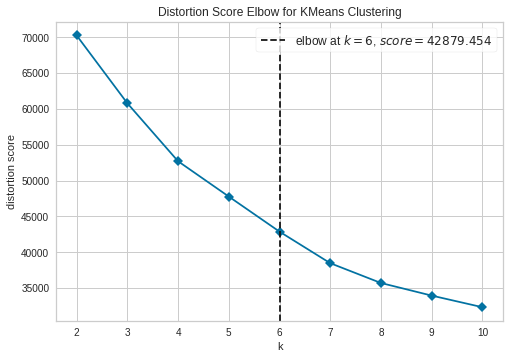

In [ ]:
plot_model(kmeans, plot = 'elbow')

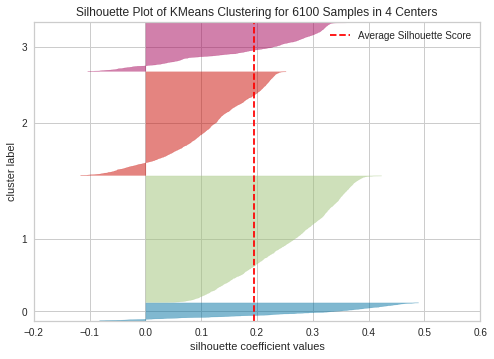

In [ ]:
plot_model(kmeans, plot = 'silhouette')
## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

# **Interpret results and plan for actions**

In [ ]:
resule_kmeans = predict_model(kmeans ,data=df_cst)
resule_kmeans.head(2)

,TotalSpend,TotalUnit,TotalVisits,TotalSKUs,FirstDate,LastDate,LIFESTAGE_OA,LIFESTAGE_OF,LIFESTAGE_OT,LIFESTAGE_PE,LIFESTAGE_YA,LIFESTAGE_YF,PRICE_SENSITIVE_LA,PRICE_SENSITIVE_MM,PRICE_SENSITIVE_UM,TicketSize,PCT_MISSION_FRESH,PCT_MISSION_GROCERY,PCT_MISSION_MIXED,PCT_MISSION_NONFOOD,PCT_WEEKEND,PCT_WEEKDAY,total_days,recency,Cluster
CUST_CODE,,,,,,,,,,,,,,,,,,,,,,,,,
CUST0000000181,2.44,1,1,1,2007-01-06,2007-01-06,0,0,0,0,0,0,0,1,0,2.440000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1,547,Cluster 3
CUST0000000369,959.33,923,220,189,2006-04-16,2008-07-05,1,0,0,0,0,0,0,1,0,4.360591,0.713636,0.145455,0.131818,0.009091,0.245455,0.754545,812,1,Cluster 0


In [ ]:
resule_kmeans.groupby(['Cluster']).mean()

,TotalSpend,TotalUnit,TotalVisits,TotalSKUs,LIFESTAGE_OA,LIFESTAGE_OF,LIFESTAGE_OT,LIFESTAGE_PE,LIFESTAGE_YA,LIFESTAGE_YF,PRICE_SENSITIVE_LA,PRICE_SENSITIVE_MM,PRICE_SENSITIVE_UM,TicketSize,PCT_MISSION_FRESH,PCT_MISSION_GROCERY,PCT_MISSION_MIXED,PCT_MISSION_NONFOOD,PCT_WEEKEND,PCT_WEEKDAY,total_days,recency
Cluster,,,,,,,,,,,,,,,,,,,,,,
Cluster 0,2515.479539,2065.991870,171.512195,366.230352,0.173442,0.075881,0.230352,0.086721,0.097561,0.211382,0.376694,0.392954,0.230352,18.529504,0.520855,0.139912,0.294572,0.036097,0.287431,0.712569,792.674797,5.669377
Cluster 1,203.495611,159.173328,20.575711,56.422752,0.119908,0.056111,0.320907,0.059185,0.151422,0.164489,0.320523,0.426211,0.237510,11.313941,0.477590,0.221094,0.214227,0.071259,0.286884,0.713116,596.121061,59.915450
Cluster 2,14.339606,10.911779,1.733458,6.750352,0.101361,0.057250,0.340685,0.048803,0.154388,0.161427,0.253402,0.389019,0.287189,8.367325,0.413264,0.307474,0.171630,0.092837,0.023387,0.976613,55.721258,422.849366
Cluster 3,12.593647,9.792585,1.661323,6.213427,0.116232,0.056112,0.335671,0.041082,0.135271,0.176353,0.260521,0.409820,0.267535,7.560661,0.419491,0.328436,0.168169,0.068865,0.857097,0.142903,60.634269,424.491984


'Cluster 0' ---> Loyalty : มาอย่างน้อยอาทิตย์ละ 1 ครั้ง ซื้อเยอะและหลากหลาย --> Action : จัดทำ Loyalty Program สะสมแต้ม
<br>'Cluster 1' ---> Potential : มองเราเป็นตัวเลือก นานๆมาที่ ซื้อของที่หลากหลาย --> Action : ดึงมาเข้าร่วม Loyalty Program/สะสมแต้ม /ส่ง Promotion ให้
<br>'Cluster 2' ---> Bussiness Traveler : ซื้อเล็กๆน้อยๆ ในวันธรรมดา --> Action : จัดโปรโมชั่นสินค้าเกี่ยวกับ GROCERY เพื่อดึงกลุ่มนี้มา
<br>'Cluster 3' ---> Tourist : ซื้อเล็กๆน้อยๆ ในวันหยุด --> Action : จัดโปรโมชั่นสินค้าเกี่ยวกับ GROCERY เพื่อดึงกลุ่มนี้มา

In [ ]:
#Create Decision Tree --> find importent freture ----> Interpert